# Model recovery attack: `credit-card`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import mra
from mra import *
import models
from models import *

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2022-04-05 16:55:10.243505: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 16:55:11.073732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [3]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")
train_ds = make_dataset(x, y, lambda t: t)

In [18]:
main = {}

for alpha1 in [100]:
    print("alpha1 = {}".format(alpha1))
    main[alpha1] = mra(train_ds)
    make_f, make_g, make_generator = models.make_mlp(
        attr_num=23,
        class_num=2,
        split=3,
        fg_units=64,
        fg_act="relu",
        generator_units=[512,256,128,64]
    )
    main[alpha1].train(
        make_f,
        make_g,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        batch_size=32,
        epoch=5,
        lr=0.001,
        alpha1=alpha1,
        verbose=True, log_every=1000
    )

alpha1 = 100
Iteration 1000: Training loss: 46.6122
Iteration 2000: Training loss: 38.8201
Iteration 3000: Training loss: 35.3742
Iteration 4000: Training loss: 34.2157


In [19]:
log_attack = {}
for alpha1 in [100]:
    print("alpha1 = {}".format(alpha1))
    log_attack[alpha1] = main[alpha1].attack(
        attack_iter=100,
        make_generator=make_generator,
        input_noise="normal",
        input_z=True,
        model_leak=True,
        lr_x=0.0001,
        lr_f=0.00001,
        epoch=50,
        iter_x=40,
        iter_f=1,
        verbose=True, log_every=1
    )

alpha1 = 100
Iteration 0001: RG-uniform: 0.2379, RG-normal: 0.2080, reconstruction validation: 0.1761
Iteration 0002: RG-uniform: 0.2465, RG-normal: 0.2072, reconstruction validation: 0.1562
Iteration 0003: RG-uniform: 0.2268, RG-normal: 0.2134, reconstruction validation: 0.1408
Iteration 0004: RG-uniform: 0.2235, RG-normal: 0.1915, reconstruction validation: 0.1500
Iteration 0005: RG-uniform: 0.2356, RG-normal: 0.2166, reconstruction validation: 0.1267
Iteration 0006: RG-uniform: 0.2353, RG-normal: 0.2057, reconstruction validation: 0.1415
Iteration 0007: RG-uniform: 0.2249, RG-normal: 0.2096, reconstruction validation: 0.1392
Iteration 0008: RG-uniform: 0.2353, RG-normal: 0.2144, reconstruction validation: 0.1360
Iteration 0009: RG-uniform: 0.2328, RG-normal: 0.2313, reconstruction validation: 0.1287
Iteration 0010: RG-uniform: 0.2480, RG-normal: 0.2236, reconstruction validation: 0.1349
Iteration 0011: RG-uniform: 0.2277, RG-normal: 0.2012, reconstruction validation: 0.1262
Iteratio

In [20]:
import pickle
with open('./log/credit-decorrelation.pkl', 'wb') as f:
    pickle.dump(log_attack, f)

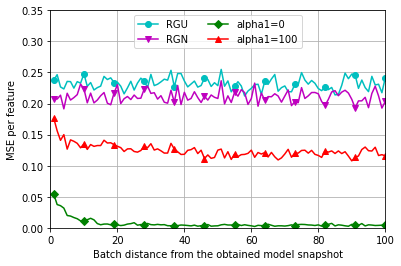

In [30]:
import matplotlib.pyplot as plt

with open('./log/credit.pkl', 'rb') as f:
    log_attack[0] = pickle.load(f)[3]

# plt.yscale('logit')
plt.xlim([0,100])
plt.ylim([0.0,0.35])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(
    ran, log_attack[100][:,0], 'co-',
    ran, log_attack[100][:,1], 'mv-',
    ran, log_attack[0][:,2], 'gD-',
    ran, log_attack[100][:,2], 'r^-',
    # ran, log_attack[128][:,2], 'bs-',
    # ran, log_attack[256][:,2], 'yx-',
    markevery=np.arange(0, 101, 9))
plt.legend(['RGU', 'RGN', 'alpha1=0', 'alpha1=100'], loc='upper center', ncol=2)
plt.savefig("fig/mra-decorrelation.pdf", bbox_inches='tight')